# Evaluation of ResNet models
We test the black and white transformation on a new set of validation images. The validation images are 400 Kodak Ektar images pulled from AnalogDB and the same images edited with the black and white LUT.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.utils as vutils
import torch.nn.functional as F

In [2]:
eval_experiment = "gan_bw_lut"
eval_filepath = "gen_bw.pth.tar"
learning_rate = 0.001
batch_size=64

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        return F.relu(out)

In [5]:
class ResNetLUTGenerator(nn.Module):
    def __init__(self, lut_size=8, trilinear=True, input_channels=3):
        super(ResNetLUTGenerator, self).__init__()
        self.lut_size = lut_size
        self.trilinear = trilinear
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # ResNet feature extraction
        self.layer1 = self._make_layer(32, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # LUT generator
        self.lut_generator = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, lut_size * lut_size * lut_size * 3)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        return ResidualBlock(in_channels, out_channels, stride)


    def _trilinear_interpolation(self, luts, images):
        # Scale images to be between -1 and 1
        img = (images - 0.5) * 2.0  # Shape: [4, 3, 256, 256]
    
        # Add a singleton dimension to represent "channel" for LUT interpolation
        img = img.permute(0, 2, 3, 1).unsqueeze(1)  # Shape: [4, 1, 256, 256, 3]
    
        # Ensure LUT is in the correct format
        LUT = luts.permute(0, 4, 1, 2, 3)  # Shape: [4, 3, 8, 8, 8]
    
        # Perform grid sampling for each channel
        result = F.grid_sample(LUT, img, mode='bilinear', padding_mode='border', align_corners=True)  # [4, 3, 1, 256, 256]
    
        # Remove the singleton dimension and permute to the correct format
        result = result.squeeze(2)  # Remove the extra "depth" dimension: [4, 3, 256, 256]
    
        return result

    def _simple_approach(self, luts, images):
        lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
        image_normalized = (images * luts.shape[2]-1).long()
        image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
            
        r = image_normalized[:, 0, :, :]
        g = image_normalized[:, 1, :, :]
        b = image_normalized[:, 2, :, :]
            
        transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
        transformed = transformed.permute(0, 3, 1, 2)

        return transformed


    def forward(self, x):
        # Feature extraction
        x_orig = x  # Store original input
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global pooling and feature compression
        features = self.global_pool(x).view(x.size(0), -1)
        
        # Generate LUT
        lut = self.lut_generator(features)
        lut = lut.view(-1, self.lut_size, self.lut_size, self.lut_size, 3)
        lut = torch.sigmoid(lut)
        
        # Apply LUT to original input
        if self.trilinear:
            transformed = self._trilinear_interpolation(lut, x_orig)
        else:
            transformed = self._simple_approach(lut, x_orig)
        return transformed, lut

### Load model

In [6]:
eval_model = ResNetLUTGenerator(lut_size=33, trilinear=False).to(device)
eval_optimizer = optim.Adam(eval_model.parameters(), lr=learning_rate)

In [7]:
def load_checkpoint(model, optimizer, experiment, filepath):
    
    filepath = f"models/{experiment}/{filepath}"
    print(f"=> Loading checkpoint from {filepath}")
    checkpoint = torch.load(filepath, weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [8]:
eval_generator, _ = load_checkpoint(eval_model, eval_optimizer, eval_experiment, eval_filepath)

=> Loading checkpoint from models/gan_bw_lut/gen_bw.pth.tar


### Load model that was trained with CNN for comparison

In [24]:
def load_checkpoint(model, optimizer, experiment, filepath):
    filepath = f"{experiment}/{filepath}"
    print(f"=> Loading checkpoint from {filepath}")
    checkpoint = torch.load(filepath, weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [25]:
eval_experiment2 = "../01_CNN_Img2LUT/models/bw_w_interpolation"
eval_filepath2 = "img2lut_bw_w_interpolation.pth.tar"
eval_model2 = ResNetLUTGenerator(lut_size=33, trilinear=True).to(device)
eval_optimizer2 = optim.Adam(eval_model2.parameters(), lr=learning_rate)
eval_generator_interpol, _ = load_checkpoint(eval_model2, eval_optimizer2, eval_experiment2, eval_filepath2)

=> Loading checkpoint from ../01_CNN_Img2LUT/models/bw_w_interpolation/img2lut_bw_w_interpolation.pth.tar


In [26]:
class PairedImageDataset(Dataset):
    def __init__(self, ungraded_images, graded_images, transform=None):
        self.ungraded_images = ungraded_images
        self.graded_images = graded_images
        self.transform = transform

    def __len__(self):
        return len(self.ungraded_images)

    def __getitem__(self, idx):
        # Returns an ungraded and a graded image
        ungraded = self.ungraded_images[idx]
        graded = self.graded_images[idx]
        if self.transform:
            ungraded = self.transform(ungraded)
            graded = self.transform(graded)
        return ungraded, graded

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [28]:
transform64 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

## Is the generated LUT always the same?

In [29]:
luts = []
for i in range(5):
    sample_input = torch.rand(1, 3, 64, 64).to(device)
    _, lut = eval_model(sample_input)
    luts.append(lut)

In [30]:
total_difference = sum(torch.sum(torch.abs(luts[i] - luts[j])) for i in range(len(luts)) for j in range(i + 1, len(luts)))

print(f"Total sum of differences: {total_difference}")

Total sum of differences: 25712.322265625


The generated LUT appears to be image adaptive / not always the same.

## Performance on test images (Kodak Ektar not Ultramax)

In [31]:
def load_images_from_directory(directory_path, num_images=100, apply_transform=True):
    images = []
    files = os.listdir(directory_path)
    # Ensure only images are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Convert to RGB in case of grayscale
        if apply_transform:
            img = transform64(img)  # Apply the transformations

        else:
            img = transform(img)
        images.append(img)
        
    images_tensor = torch.stack(images)
    images_tensor = images_tensor.permute(0, 2, 3, 1)
    return images_tensor

ungraded_images = load_images_from_directory('../../analogdb_images_scaled/kodak_ektar', num_images=400)
graded_images = load_images_from_directory('../../analogdb_images_scaled/kodak_ektar/BW', num_images=400)

# Verify the shape of the tensors
print(ungraded_images.shape)  
print(graded_images.shape)

torch.Size([400, 256, 256, 3])
torch.Size([400, 256, 256, 3])


In [32]:
ungraded_images_np = ungraded_images.numpy()
graded_images_np = graded_images.numpy()

dataset = PairedImageDataset(ungraded_images_np, graded_images_np, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [33]:
ungraded, graded = next(iter(dataloader))

In [37]:
ungraded = ungraded.to(device)
edited_images, luts = eval_generator(ungraded)
edited_images_cnn, luts = eval_generator_interpol(ungraded)

In [35]:
def calc_mse(images1, images2):
    mse = torch.mean((images1 - images2) ** 2)
    return mse

In [38]:
mse = calc_mse(graded.to(device),edited_images)
mse_cnn = calc_mse(graded.to(device),edited_images_cnn)

In [39]:
print(mse)
print(mse_cnn)

tensor(0.0205, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)


In [40]:
print(f"Difference between MSE:{mse-mse_cnn}")

Difference between MSE:0.020386453717947006


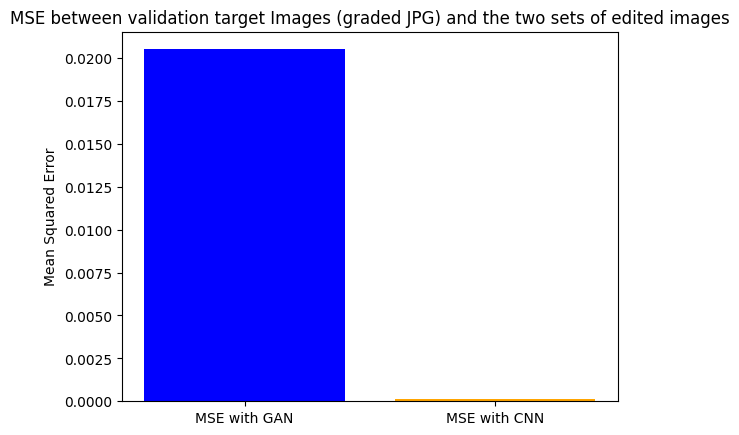

In [42]:
labels = ['MSE with GAN', 'MSE with CNN']
values = [mse.cpu().item(), mse_cnn.cpu().item()]

plt.bar(labels, values, color=['blue', 'orange'])

# Add labels and title
plt.ylabel('Mean Squared Error')
plt.title('MSE between validation target Images (graded JPG) and the two sets of edited images')

plt.show()

In [43]:
def display_image(image, width=256):
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    image = Image.fromarray(image_np)
    display(image)

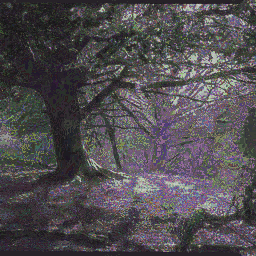

In [44]:
display_image(edited_images[0])

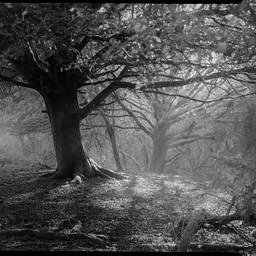

In [46]:
display_image(edited_images_cnn[0])

# Conclusion

On the validation images we got a MSE of around 0.02 for our GAN trained model on unpaired image data, which is significantly worse than the MSE of around 0.0001 that we achieved with the CNN trained on paired image data. This is in line with what we can see in the visual comparison above. The remaining problem is that the GAN might successfully learn the style translation between different domains, in this case analog films, but the generated 3D LUTs and images still show a lot of unwanted artifacts and noise. We can see these artifacts and broken color transitions in the first image above.

To reduce these artifacts and to further improve stability we adapted the architecture of a CycleGAN in the next step.